# Identify family interactions based on if they shared the same objects

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import tqdm
from datetime import datetime

from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import community as community_louvain

## load data

In [2]:
baseDir = '../data/publicMapChangeData/bigserver2.onehouronelife.com/'

In [3]:
start = 1573982073

read all mapChange data

In [4]:
str_extract = lambda pattern, s: re.search(pattern, s).group(0)
int_extract = lambda pattern, s: int(str_extract(pattern, s))

In [5]:
files_tot = []
for ts in glob.glob(baseDir + '*'):
    files_tot.append(ts)

In [6]:
file_names = []
for f in files_tot:
    fn = f.split('/')[-1]
    file_names.append(fn)

sort according to timestamp

In [7]:
file_names.sort(key=lambda f: int_extract('[0-9]+(?=)', f))

In [8]:
file_names

['1573895673time_mapLog.txt',
 '1573895673time_mapSeed.txt',
 '1573982073time_mapLog.txt',
 '1574068473time_mapLog.txt',
 '1574102503time_mapLog.txt',
 '1574102503time_mapSeed.txt',
 '1574151679time_mapLog.txt',
 '1574238079time_mapLog.txt',
 '1574324479time_mapLog.txt',
 '1574410879time_mapLog.txt',
 '1574497279time_mapLog.txt',
 '1574552311time_mapLog.txt',
 '1574638711time_mapLog.txt',
 '1574725111time_mapLog.txt',
 '1574749280time_mapLog.txt',
 '1574835680time_mapLog.txt',
 '1574848832time_mapLog.txt',
 '1574935232time_mapLog.txt',
 '1575021632time_mapLog.txt',
 '1575108032time_mapLog.txt',
 '1575194432time_mapLog.txt',
 '1575280833time_mapLog.txt',
 '1575367233time_mapLog.txt',
 '1575453633time_mapLog.txt',
 '1575540033time_mapLog.txt',
 '1575626433time_mapLog.txt',
 '1575693816time_mapLog.txt',
 '1575780216time_mapLog.txt',
 '1575866616time_mapLog.txt',
 '1575953016time_mapLog.txt',
 '1576038671time_mapLog.txt',
 '1576038671time_mapSeed.txt',
 '1576125071time_mapLog.txt',
 '15762

create a dictionary for mapSeed -- mapLog

In [9]:
map_seeds = [int_extract('[0-9]+(?=)', fn) for fn in file_names if 'mapSeed' in fn]
map_seeds

[1573895673,
 1574102503,
 1576038671,
 1578345720,
 1578354747,
 1579713519,
 1580144896,
 1581985139,
 1583642903,
 1584061484,
 1585440511,
 1585512770,
 1585603481,
 1587166656]

In [10]:
file_dict = {}
for fn in file_names:
    timestamp = int_extract('[0-9]+(?=)', fn)
    if timestamp in map_seeds:
        map_start = timestamp
        file_dict[map_start] = [timestamp]
    else:
        file_dict[map_start].append(timestamp)

In [11]:
file_dict

{1573895673: [1573895673, 1573982073, 1574068473],
 1574102503: [1574102503,
  1574151679,
  1574238079,
  1574324479,
  1574410879,
  1574497279,
  1574552311,
  1574638711,
  1574725111,
  1574749280,
  1574835680,
  1574848832,
  1574935232,
  1575021632,
  1575108032,
  1575194432,
  1575280833,
  1575367233,
  1575453633,
  1575540033,
  1575626433,
  1575693816,
  1575780216,
  1575866616,
  1575953016],
 1576038671: [1576038671,
  1576125071,
  1576211471,
  1576295889,
  1576303914,
  1576372684,
  1576437742,
  1576454784,
  1576541127,
  1576627527,
  1576713927,
  1576800327,
  1576886727,
  1576905906,
  1576992306,
  1577078706,
  1577165106,
  1577251506,
  1577337906,
  1577424306,
  1577510707,
  1577597107,
  1577683507,
  1577769907,
  1577856307,
  1577942707,
  1578029107,
  1578101918,
  1578188318,
  1578274718],
 1578345720: [1578345720],
 1578354747: [1578354747,
  1578441147,
  1578527547,
  1578610753,
  1578697153,
  1578783553,
  1578869953,
  1578956353,
  

### test: only look at the first slice

In [12]:
subset = file_dict[list(file_dict.keys())[0]]
subset

[1573895673, 1573982073, 1574068473]

In [13]:
start = pd.read_csv(baseDir + str(subset[0]) + 'time_mapLog.txt')
time0 = float(start.columns[0].split(": ")[1])
print(time0)

1573895672.99


In [14]:
col = ['time','locX','locY','obj','playerID']
data = pd.DataFrame(columns = col)
for i in subset:
    mydf = pd.read_csv(baseDir + str(i) + 'time_mapLog.txt')
    start_time = float(mydf.columns[0].split(": ")[1])
    mydf[['time','locX','locY','obj','playerID']] = mydf[mydf.columns[0]].str.split(" ", expand=True)
    mydf = mydf.dropna()
    mydf['time'] = mydf['time'].astype(float) + start_time - time0
    mydf['playerID'] = mydf['playerID'].astype(int)
    print(len(mydf))
    mydf = mydf[col]
    data = data.append(mydf, ignore_index = True)

1015275
1414424
425470


In [15]:
data.head(n = 10)

,time,locX,locY,obj,playerID
0,82.36,-5123,-1403,74,-1
1,82.36,-5139,-1398,2919,-1
2,82.36,-5138,-1398,2917,-1
3,82.36,-5137,-1398,198,-1
4,82.36,-5136,-1398,2099,-1
5,82.36,-5136,-1397,2884,-1
6,82.37,-5137,-1383,198,-1
7,122.31,-5137,-1395,0,2276905
8,125.06,-5138,-1394,0,2276905
9,127.21,-5138,-1395,0,-1


In [26]:
duration = max(data.time) - min(data.time)
duration

206688.01999998093

## Focus on location and family

### load family data and write a find_family function

In [16]:
fam= pd.read_csv('../2_demographics/outputs/family_playerID.tsv', sep = '\t', index_col = 0)
fam.head(n=10)

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,playerID,family
0,3080084,time-1592284232_eve-3080067_name-PICKLE
1,3080114,time-1592284232_eve-3080067_name-PICKLE
2,3080111,time-1592284232_eve-3080067_name-PICKLE
3,3080108,time-1592284232_eve-3080067_name-PICKLE
4,3080104,time-1592284232_eve-3080067_name-PICKLE
5,3080130,time-1592284232_eve-3080067_name-PICKLE
6,3080122,time-1592284232_eve-3080067_name-PICKLE
7,3080117,time-1592284232_eve-3080067_name-PICKLE
8,3080067,time-1592284232_eve-3080067_name-PICKLE
9,3080044,time-1592283401_eve-3080044_name-KORE


In [17]:
def find_fam(playerId):
    
    family = fam.loc[fam['playerID'] == playerId,'family'].tolist()
    if len(family):    
        fam_name = family[0].split('-')[-1]
    else:
        fam_name = fam_name = "UnKnown"
    
    return fam_name

check if every player has a last name (No!) and find the number of players in a family

In [18]:
fam_dict = {}
family_dict = {}
for i in data['playerID'].unique():
    if (i != -1) and (i != 0):
        family = fam.query('playerID == @i')['family'].values
        if len(family):
            family_name = family[0].split('-')[-1]
            family_dict[i] = family_name
            if family_name in fam_dict.keys():
                fam_dict[family_name] = fam_dict[family_name]+1
            else:
                fam_dict[family_name] = 1


In [19]:
family_dict

{2276905: 'ZABICKI',
 2276911: 'ROHRER',
 2276906: 'ZABICKI',
 2276909: 'ZABICKI',
 2276912: 'ROHRER',
 2276919: 'SARINA',
 2276917: 'BADA',
 2276914: 'ZABICKI',
 2276913: 'ROHRER',
 2276918: 'BADA',
 2276921: 'SARINA',
 2276927: 'LISSADE',
 2276922: 'ZABICKI',
 2276923: 'BADA',
 2276925: 'SARINA',
 2276926: 'BADA',
 2276928: 'SARINA',
 2276931: 'ZABICKI',
 2276929: 'ZABICKI',
 2276930: 'ZABICKI',
 2276935: 'ZABICKI',
 2276938: 'ZABICKI',
 2276937: 'SARINA',
 2276936: 'BADA',
 2276939: 'SARINA',
 2276940: 'LISSADE',
 2276941: 'ZABICKI',
 2276945: 'SARINA',
 2276946: 'BADA',
 2276948: 'SARINA',
 2276949: 'LISSADE',
 2276951: 'BADA',
 2276950: 'ZABICKI',
 2276952: 'SARINA',
 2276953: 'BADA',
 2276954: 'ZABICKI',
 2276958: 'LISSADE',
 2276955: 'LISSADE',
 2276959: 'ZABICKI',
 2276957: 'ZABICKI',
 2276960: 'BADA',
 2276965: 'BADA',
 2276966: 'ZABICKI',
 2276967: 'BADA',
 2276968: 'BADA',
 2276970: 'ZABICKI',
 2276971: 'SARINA',
 2276969: 'LISSADE',
 2276973: 'ZABICKI',
 2276974: 'SARINA',


## record connection in a dataframe

Sort by location and time

In [20]:
parsed = data.sort_values(by = ['locX','locY','time']).copy()
parsed.head()

,time,locX,locY,obj,playerID
351066,24031.04,-10,-1,3202,-1
953623,49855.63,-10000,-1011,0,2279625
879164,46166.64,-10000,-1025,0,2279421
879179,46167.52,-10000,-1025,2504,2279421
952037,49726.09,-10000,-1042,2144,2279625


tag previous player and object at this location

In [21]:
parsed['same_loc'] = parsed.locY.eq(parsed.locY.shift())

In [22]:
parsed['all_prev_obj'] = parsed.obj.shift()
parsed['prev_obj'] = parsed[parsed['same_loc']==True]['all_prev_obj']
parsed['all_prev_playerID'] = parsed.playerID.shift()
parsed['prev_playerID'] = parsed[parsed['same_loc']==True]['all_prev_playerID']

In [23]:
parsed = parsed[['time','locX','locY','obj','playerID','prev_obj','prev_playerID']]
parsed.head(n = 10)

,time,locX,locY,obj,playerID,prev_obj,prev_playerID
351066,24031.04,-10,-1,3202,-1,NaN,NaN
953623,49855.63,-10000,-1011,0,2279625,NaN,NaN
879164,46166.64,-10000,-1025,0,2279421,NaN,NaN
879179,46167.52,-10000,-1025,2504,2279421,0,2279421
952037,49726.09,-10000,-1042,2144,2279625,NaN,NaN
1049318,91043.70,-10000,-1101,32,2281593,NaN,NaN
636021,38260.68,-10000,-1111,0,-1,NaN,NaN
636022,38260.68,-10000,-1111,2143,2279006,0,-1
636054,38262.68,-10000,-1111,0,2279006,2143,2279006
2400152,170281.03,-10000,-148,0,2285314,NaN,NaN


take data where an object at a location was changed by a different player

In [24]:
parsednew = parsed.loc[(parsed.obj != parsed.prev_obj) & (parsed.prev_obj != "0") & (parsed.playerID != parsed.prev_playerID)
                       & (parsed.prev_playerID != -1) & (parsed.playerID != -1)].dropna()
parsednew = parsednew.sort_values(by = ['time'])

In [27]:
parsednew.head(n = 10)

,time,locX,locY,obj,playerID,prev_obj,prev_playerID
166,466.06,-7622,-611,30u3,2276911,30u4,2276912
178,474.73,-5125,-1393,2873u1,2276906,2873u2,2276905
234,511.16,-5123,-1392,2742u2,2276909,2742u3,2276905
245,516.87,-5123,-1392,2742u1,2276905,2742u2,2276909
257,522.20,-5123,-1392,2742u0,2276914,2742u1,2276905
258,523.12,-5124,-1389,0,2276905,1242u0,2276906
314,548.22,-5123,-1392,402,2276909,2742u0,2276914
379,570.19,-7638,-576,30u2,2276911,30u3,2276913
445,600.28,-5128,-1400,1603u1,2276914,1603u2,2276906
521,630.58,-5118,-1403,0,2276905,2201,2276909


In [31]:
# parsednew['player_fam'] = parsednew['playerID'].apply(find_fam)
# parsednew['prev_player_fam'] = parsednew['prev_playerID'].apply(find_fam)

count the number of interactions between players (defined as two players interacted with the same object)

In [28]:
grouped = parsednew.groupby(['playerID','prev_playerID'])['time'].count().to_frame().reset_index()
grouped.head()

,playerID,prev_playerID,time
0,2276905,2276906,1
1,2276905,2276909,22
2,2276905,2276914,3
3,2276905,2276922,3
4,2276905,2276929,2


In [29]:
G = nx.from_pandas_edgelist(parsednew, 'playerID', 'prev_playerID') 
partition = community_louvain.best_partition(G)

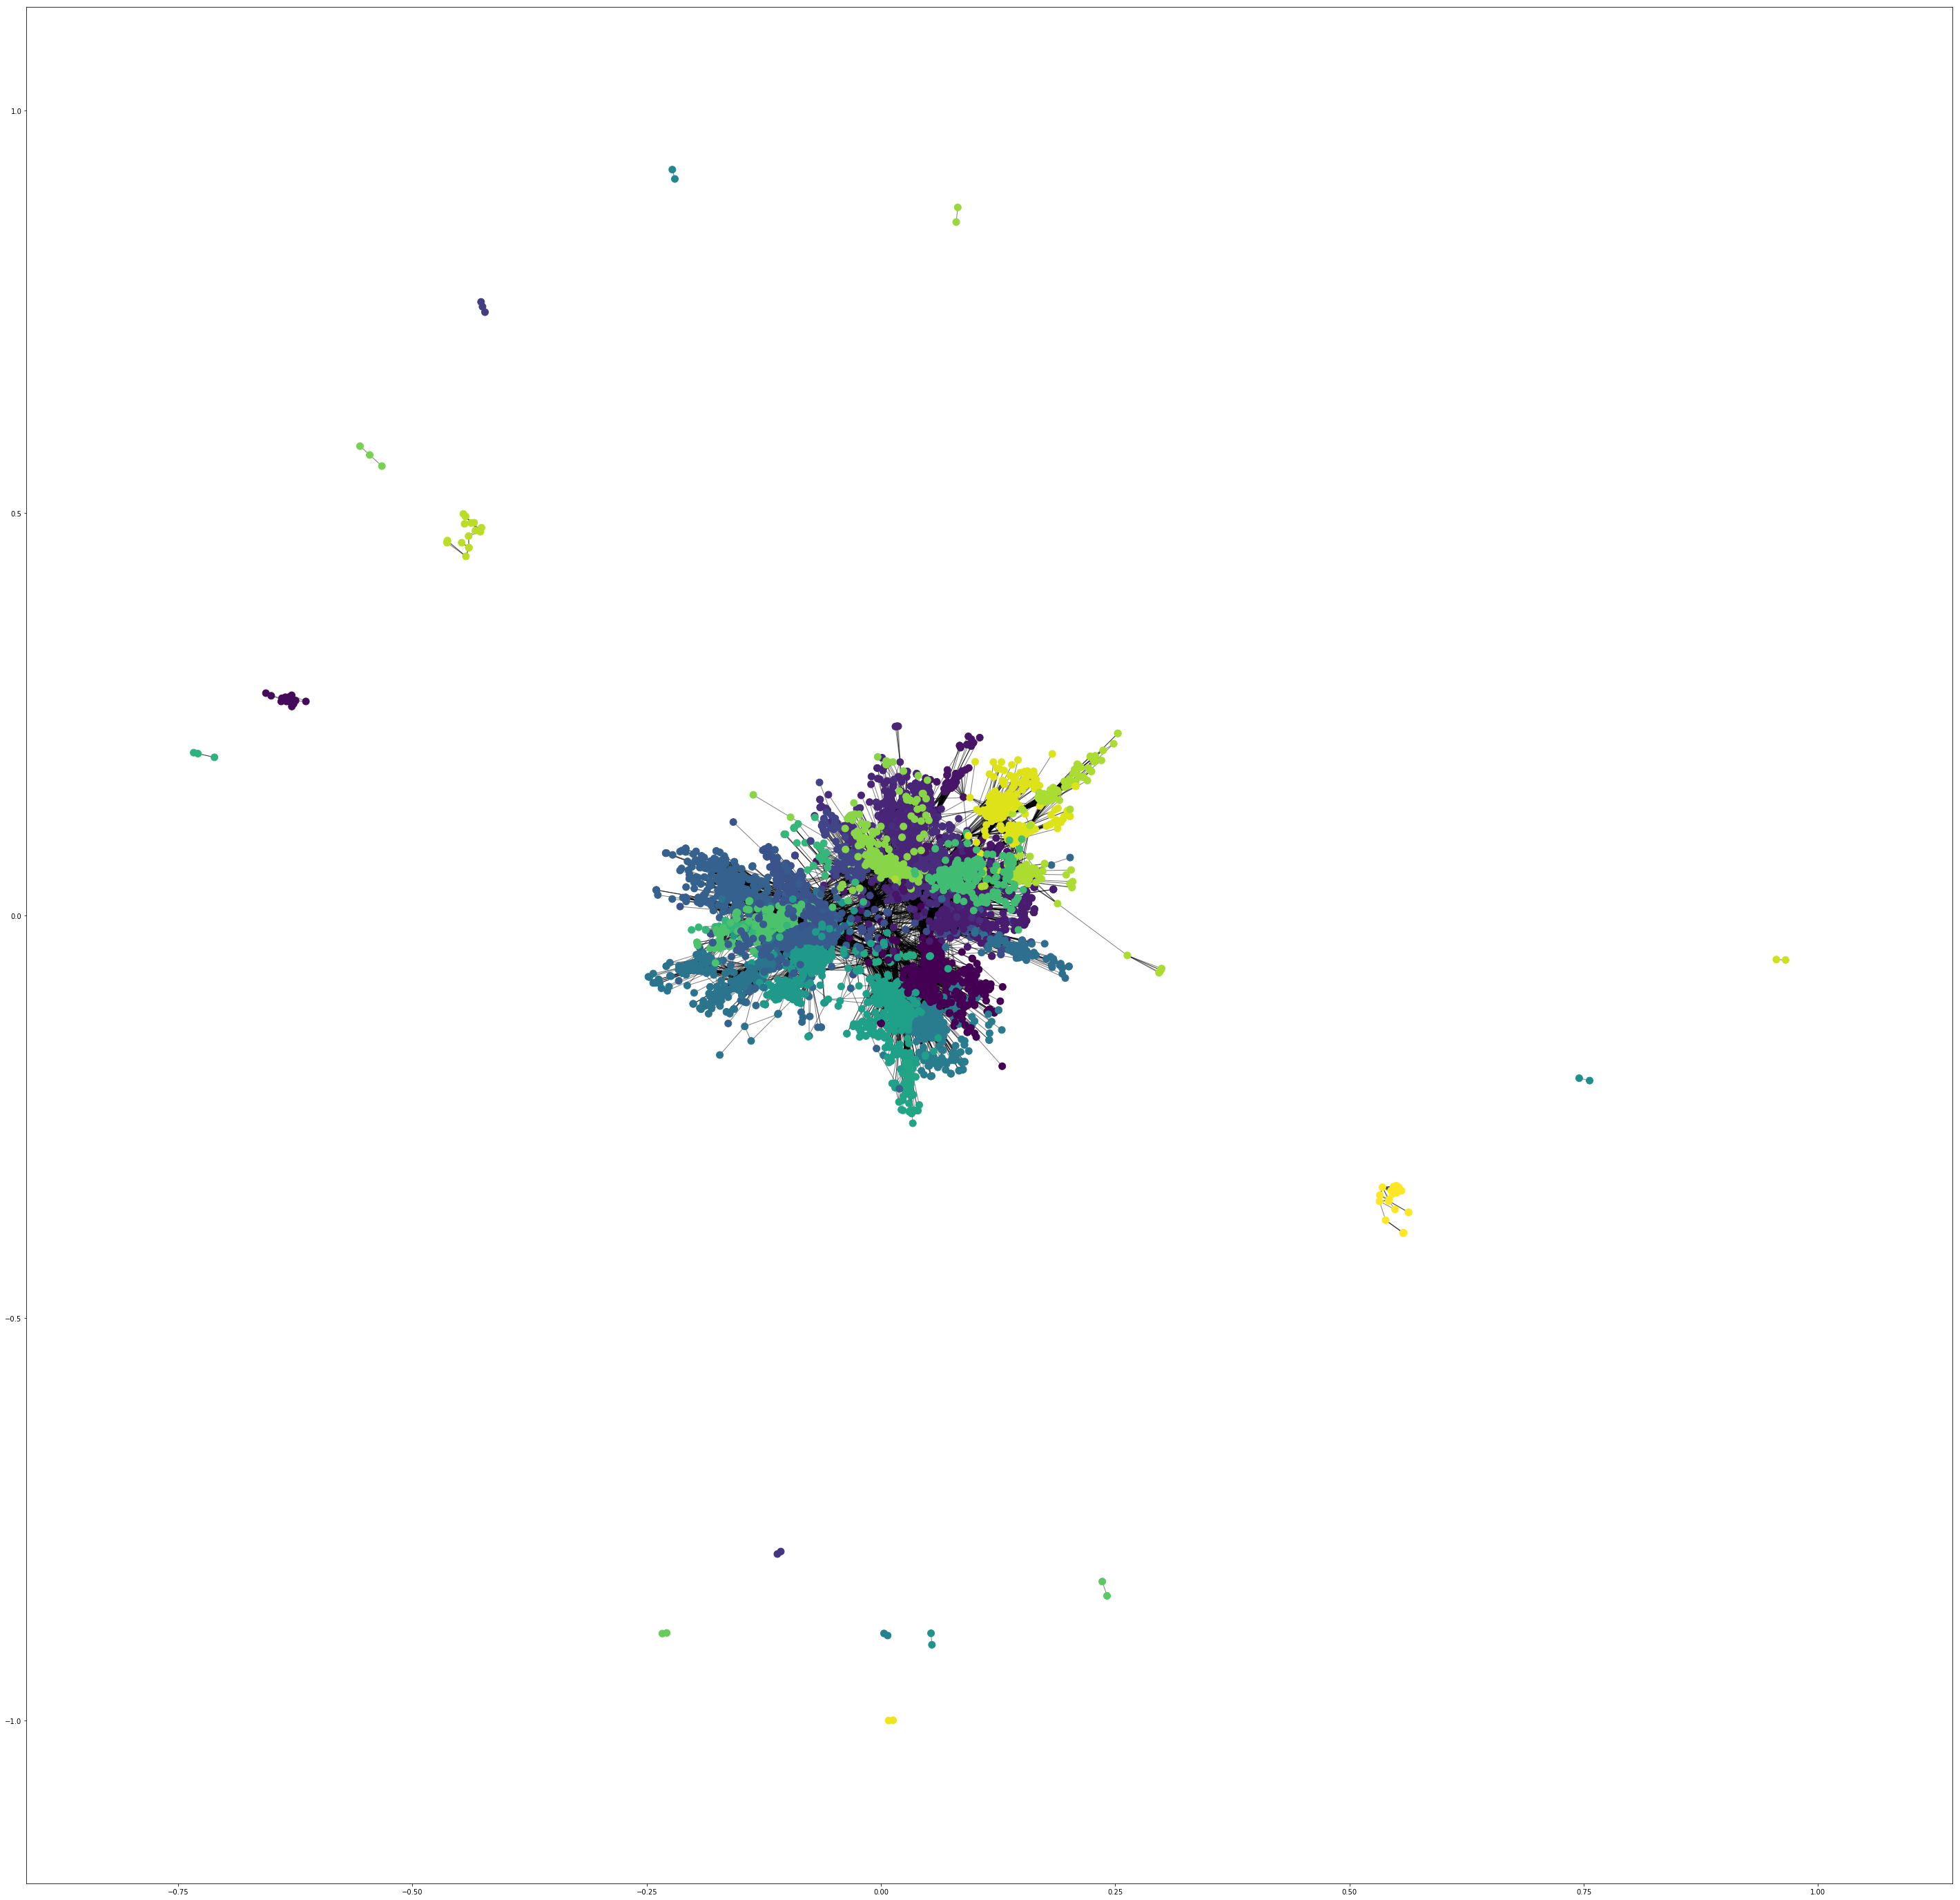

In [29]:
plt.figure(figsize=(50,50))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.savefig('louvain.png', dpi = 100)

In [30]:
partition

{2276911: 0,
 2276912: 0,
 2276906: 1,
 2276905: 1,
 2276909: 1,
 2276914: 1,
 2276913: 0,
 2276918: 2,
 2276917: 2,
 2276921: 2,
 2276919: 2,
 2276923: 2,
 2276925: 2,
 2276922: 1,
 2276926: 2,
 2276928: 2,
 2276931: 1,
 2276929: 1,
 2276930: 1,
 2276935: 1,
 2276938: 1,
 2276936: 2,
 2276937: 2,
 2276939: 2,
 2276940: 2,
 2276927: 2,
 2276941: 1,
 2276946: 2,
 2276948: 2,
 2276945: 2,
 2276949: 2,
 2276954: 1,
 2276955: 2,
 2276959: 1,
 2276957: 1,
 2276961: 2,
 2276965: 2,
 2276960: 2,
 2276962: 1,
 2276966: 1,
 2276958: 2,
 2276967: 2,
 2276968: 2,
 2276971: 2,
 2276969: 2,
 2276972: 2,
 2276953: 2,
 2276974: 2,
 2276977: 2,
 2276978: 2,
 2276976: 1,
 2276970: 1,
 2276982: 2,
 2276985: 2,
 2276986: 2,
 2276989: 2,
 2276990: 2,
 2276991: 2,
 2276993: 2,
 2276994: 2,
 2276995: 2,
 2276992: 2,
 2276997: 2,
 2276999: 2,
 2277003: 2,
 2277001: 2,
 2277007: 2,
 2277005: 2,
 2277018: 2,
 2277016: 2,
 2277023: 2,
 2277000: 2,
 2277017: 2,
 2277021: 2,
 2276979: 2,
 2277019: 2,
 2277027: 2,

In [30]:
n_avatars = parsednew.playerID.unique()

In [ ]:
parsednew_with_fam = parsednew.

In [31]:
same_family = []
same_comm = []
for i in n_avatars:
    others = parsednew.loc[parsednew.playerID==i]['prev_playerID'].tolist()
    for j in others:
        try:
            same_family.append(family_dict[i] == family_dict[j])
        except KeyError: ##family name not defined
            same_family.append(np.nan)
        same_comm.append(partition[i] == partition[j])
        

In [69]:
with_fam_list = []
for i in range(len(same_family)):
    if (same_family[i] is True) or (same_family[i] is False):
        with_fam_list.append(i)


In [71]:
mydf = pd.DataFrame()
mydf['same_fam'] = same_family
mydf['same_comm'] = same_comm

In [73]:
mydf = mydf.dropna()
len(mydf)

130186

In [79]:
mydf['agreement'] = mydf.same_fam.eq(mydf.same_comm)

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [82]:
p_agree = len(mydf.loc[mydf.agreement==True])/len(mydf) 
p_agree

0.8754167114743521

In [309]:
# follower_df = parsednew.groupby(['playerID'])['time'].count().to_frame().reset_index()
# follower_df = follower_df.sort_values(by = 'time', ascending = False)
# follower_df.head()

tag family names

In [29]:
grouped_with_fam = grouped.copy()
grouped_with_fam['player_fam'] = grouped_with_fam['playerID'].map(find_fam)
grouped_with_fam['prev_player_fam'] = grouped_with_fam['prev_playerID'].map(find_fam)

In [314]:
grouped_with_fam.head(n=10)

,playerID,prev_playerID,time,player_fam,prev_player_fam
0,2276905,2276906,1,ZABICKI,ZABICKI
1,2276905,2276909,22,ZABICKI,ZABICKI
2,2276905,2276914,3,ZABICKI,ZABICKI
3,2276905,2276922,3,ZABICKI,ZABICKI
4,2276905,2276929,2,ZABICKI,ZABICKI
5,2276905,2276930,1,ZABICKI,ZABICKI
6,2276905,2276931,1,ZABICKI,ZABICKI
7,2276905,2276941,5,ZABICKI,ZABICKI
8,2276905,2276954,1,ZABICKI,ZABICKI
9,2276906,2276905,1,ZABICKI,ZABICKI


plot player interactions

In [ ]:
sorteddf = parsednew.copy()
sorteddf[['playerID','prev_playerID']]=np.sort(sorteddf[['playerID','prev_playerID']],1)
sortednew = sorteddf.groupby(['playerID','prev_playerID'])['time'].count().to_frame().reset_index()

In [420]:
unique_fams = list(set(np.append(sortednew.player_fam.unique(), sortednew.previous_player_fam.unique())))
colors = {}
for i in unique_fams:
    colors[i] = list(np.random.choice(range(256), size=3)/256)

In [421]:
G = nx.from_pandas_edgelist(sortednew, 'playerID', 'prev_playerID') 
nodes = G.nodes()
color = [colors[find_fam(n)] for n in nodes] ##assign colors to nodes based on family

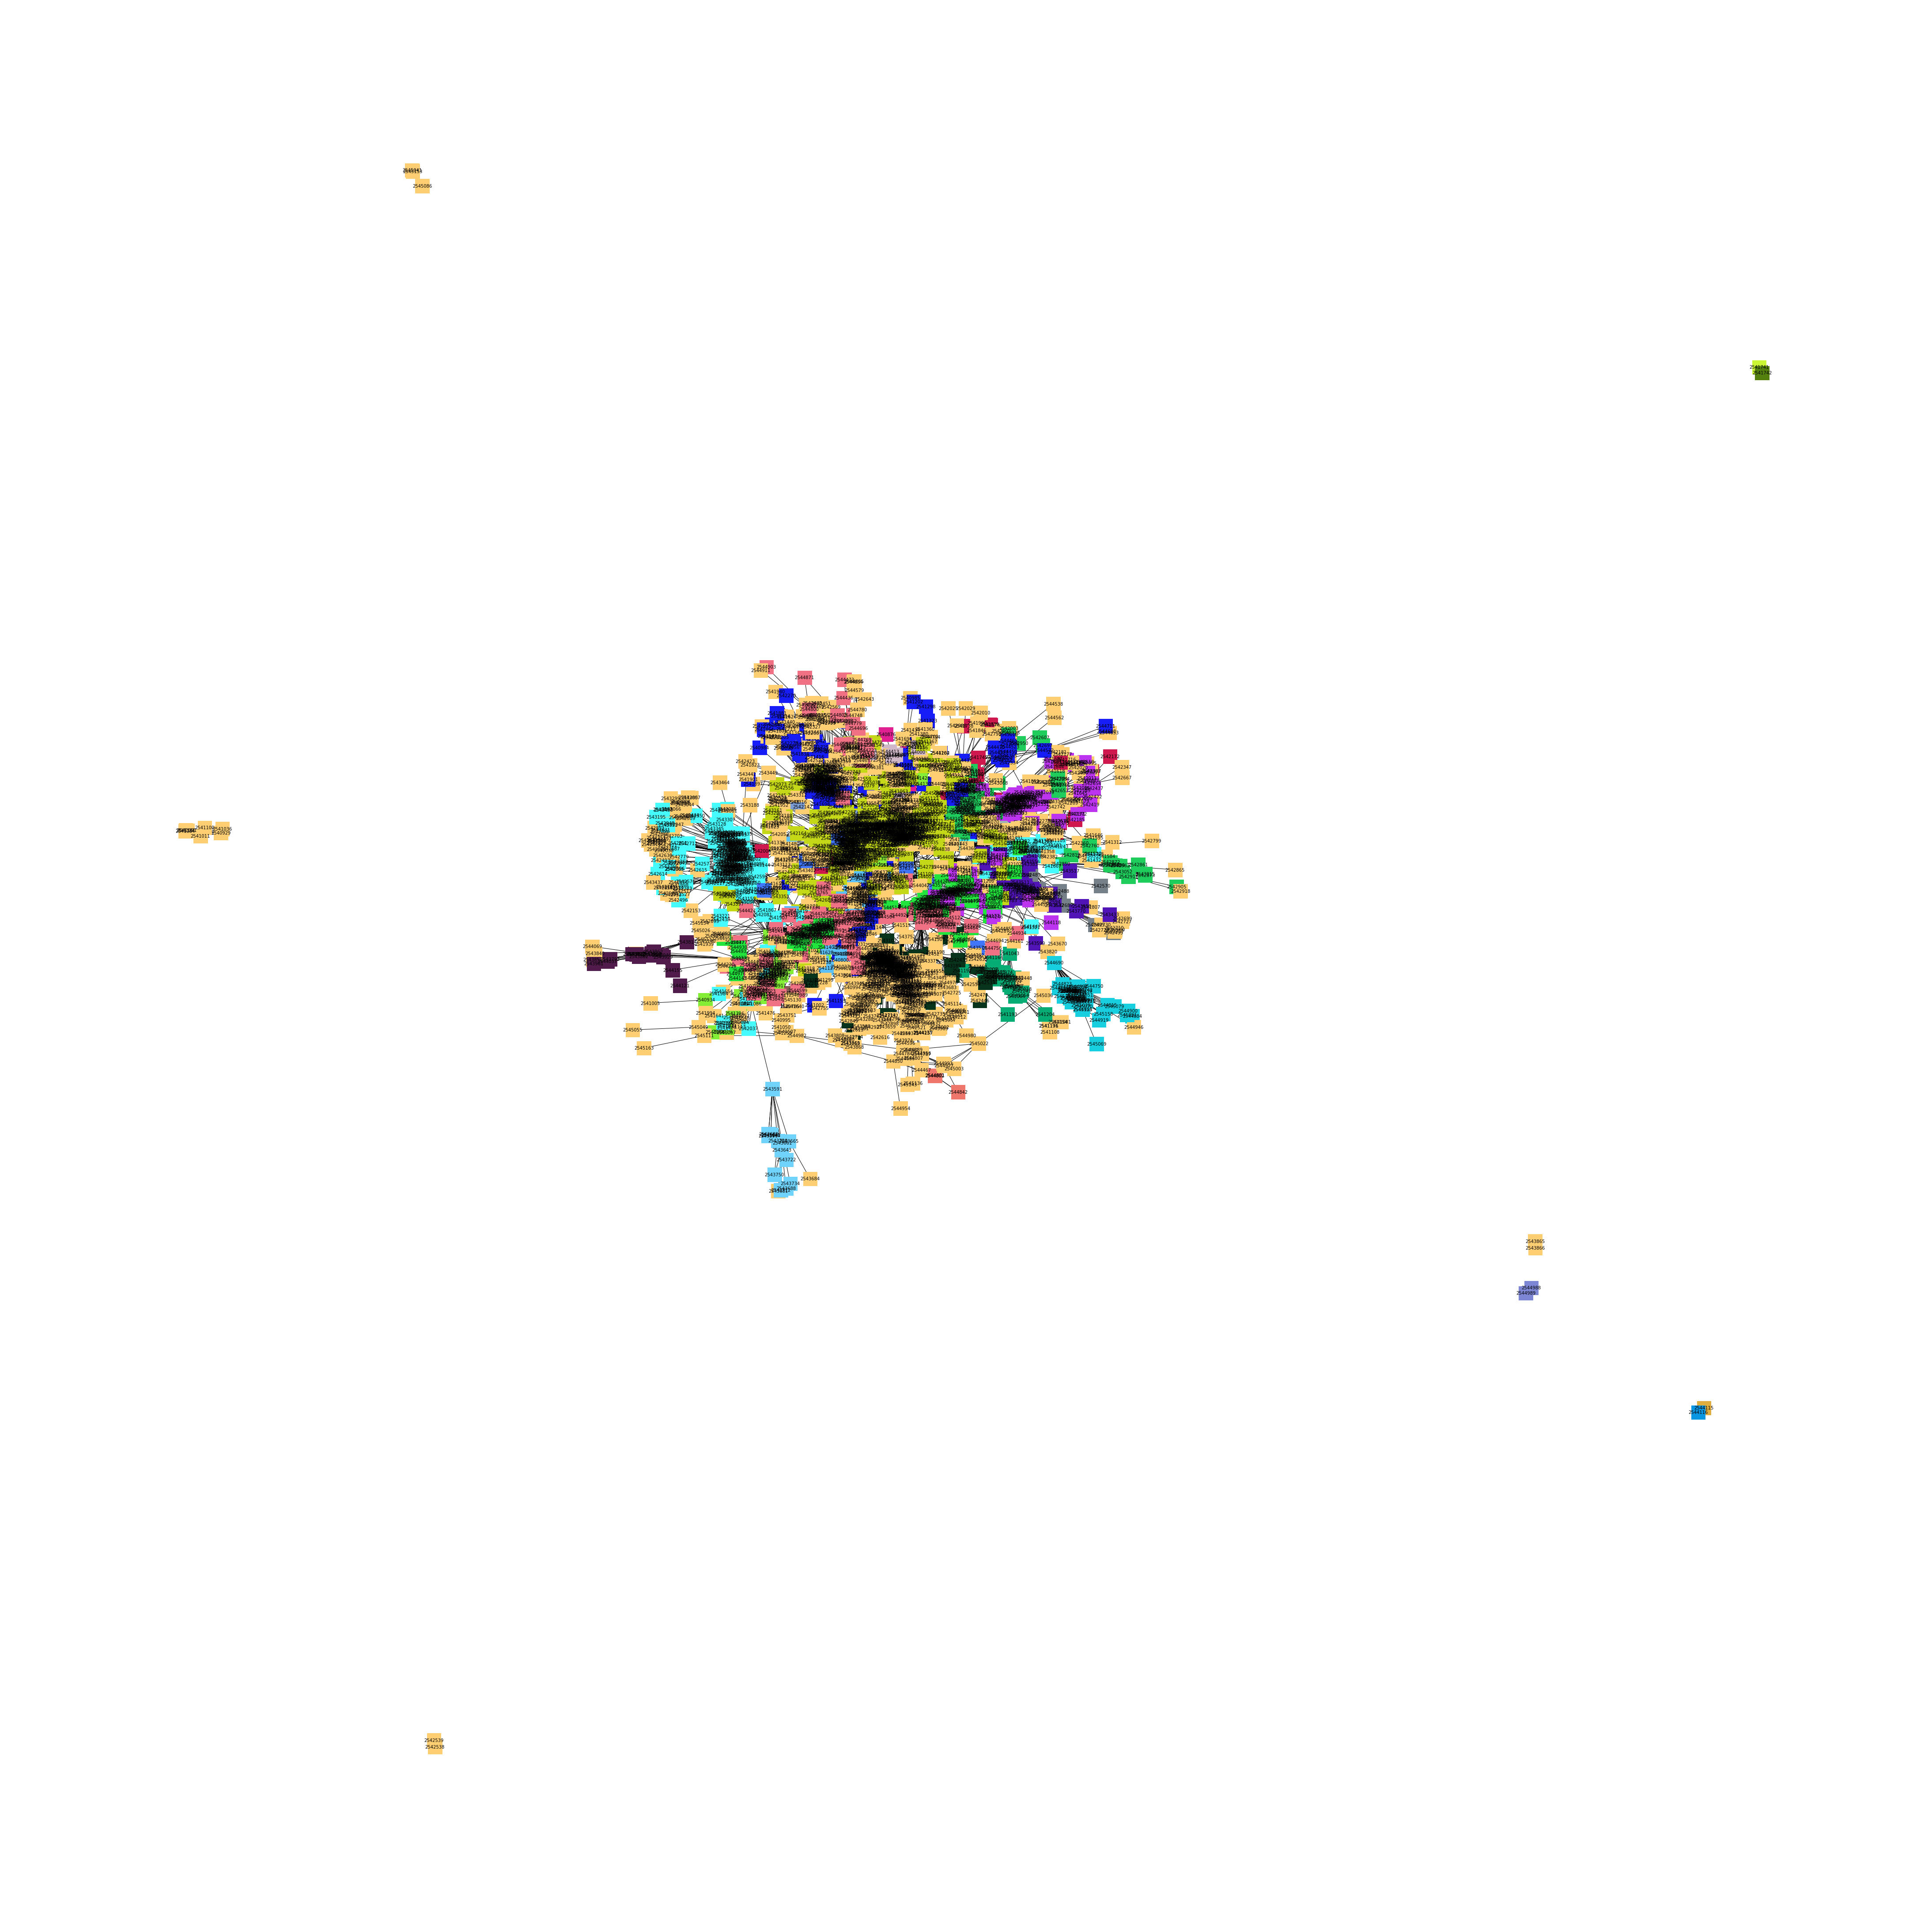

In [431]:
plt.figure(figsize=(60,60))
pos = nx.spring_layout(G, k=0.5/np.sqrt(len(nodes)), iterations=20) ##make nodes further apart
nx.draw(G, pos = pos, with_labels= True, node_shape='s', node_color = color, node_size=1000, font_size=10)
# plt.savefig('family.png', dpi = 100)

plot interactions by family

In [30]:
# sortednew = grouped.copy()
# sortednew[['player_fam','previous_player_fam']]=np.sort(sortednew[['player_fam','previous_player_fam']],1)
fam_df = grouped_with_fam.groupby(['player_fam','prev_player_fam'])['time'].count().to_frame().reset_index()

In [31]:
fam_df = fam_df.query('(player_fam != prev_player_fam) and (player_fam != "UnKnown") and (prev_player_fam != "UnKnown")')

In [32]:
fam_df.sort_values(by = 'time', ascending = False)

,player_fam,prev_player_fam,time
52,FINCH,ISPAS,726
83,ISPAS,FINCH,723
94,LIMEHOUSE,SCHWARZENBERGER,589
131,SCHWARZENBERGER,LIMEHOUSE,505
53,FINCH,LISSADE,423
99,LISSADE,FINCH,328
150,UNIS,GREY,318
145,UNIS,ETERNO,266
85,ISPAS,LISSADE,157
100,LISSADE,ISPAS,152


turn df to graph representation

In [33]:
G2 = nx.from_pandas_edgelist(fam_df, 'prev_player_fam','player_fam', None, nx.DiGraph()) 

set node size proportional to family size

In [34]:
ns = [200*np.sqrt(fam_dict[i]) for i in G2.nodes]

set edge width proportional to number of interactions

In [37]:
s = sum(fam_df['time'].tolist())
ew = []
for (u,v) in G2.edges:
    times = fam_df.loc[(fam_df.prev_player_fam == u) & (fam_df.player_fam == v)]['time'].values[0]
    weight = 20*np.sqrt(times/s)
    ew = np.append(ew, weight)

In [38]:
len(ew) == len(G2.edges)

True

draw graph

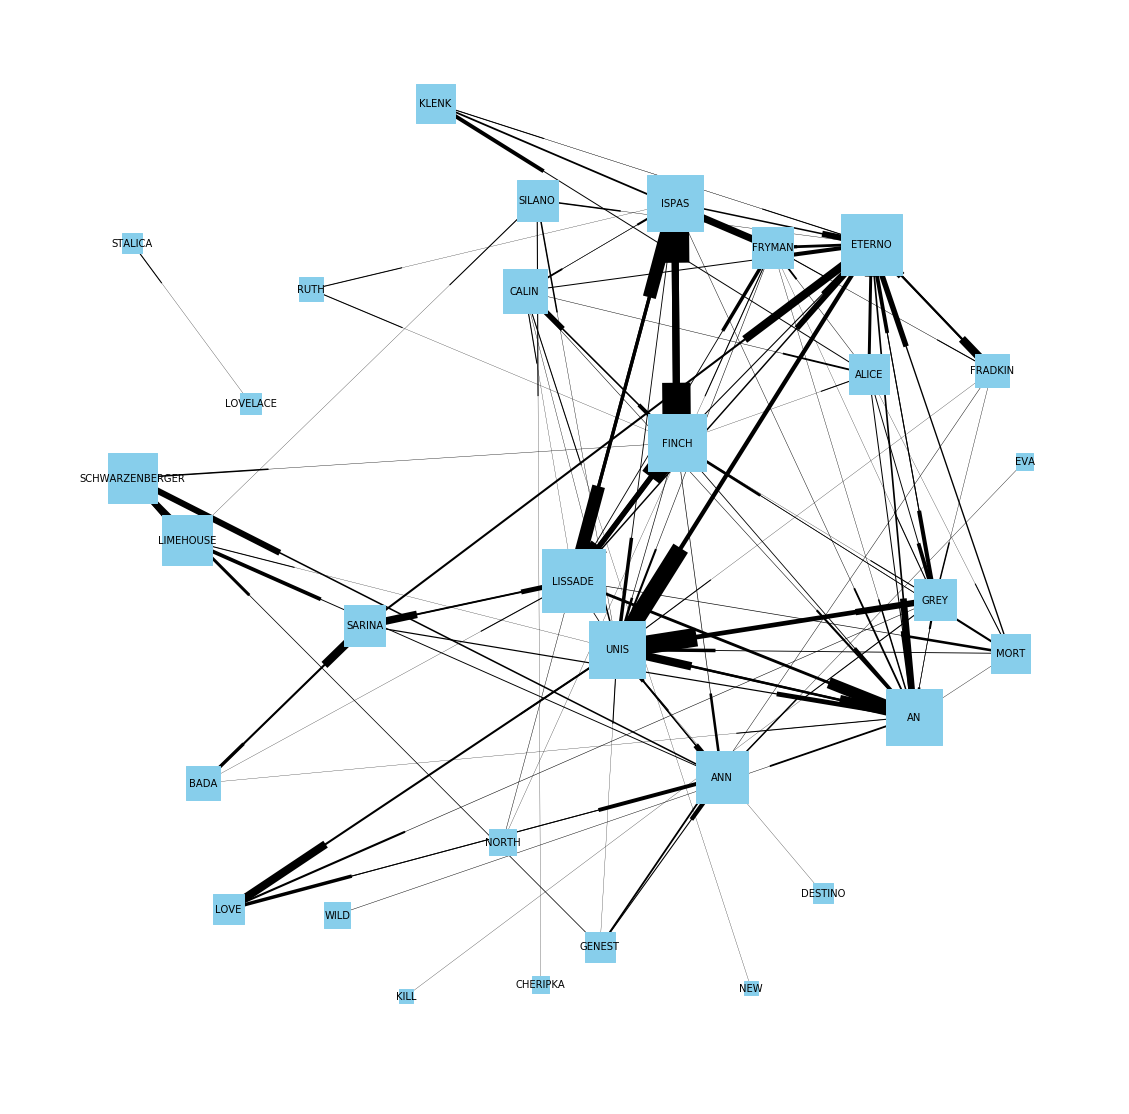

In [39]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G2, k=0.8, iterations=20) ##make nodes further apart
nx.draw(G2, pos=pos, with_labels= True, node_color='skyblue', width=ew, node_shape='s', node_size=ns, font_size=10)

plt.savefig('plots/fam_directed.png',dpi = 100)

In [108]:
G2.edges

EdgeView([('ADAMS', 'KILAR'), ('ADAMS', 'WOLF'), ('KILAR', 'AN'), ('KILAR', 'BYTHEWAY'), ('KILAR', 'DOBBIE'), ('KILAR', 'DOSHI'), ('KILAR', 'HEAVEN'), ('KILAR', 'HELL'), ('KILAR', 'KILAR'), ('KILAR', 'MENSINK'), ('KILAR', 'MERCURY'), ('KILAR', 'STRONG'), ('KILAR', 'SUN'), ('KILAR', 'VIKER'), ('KILAR', 'WOLF'), ('KILAR', 'YESAYAN'), ('WOLF', 'DOBBIE'), ('WOLF', 'MERCURY'), ('WOLF', 'SUN'), ('WOLF', 'UMBRELL'), ('WOLF', 'WOLF'), ('AN', 'AN'), ('AN', 'DOBBIE'), ('AN', 'DOSHI'), ('AN', 'HEAVEN'), ('AN', 'HELL'), ('AN', 'LOLA'), ('AN', 'PIGMAN'), ('AN', 'STRONG'), ('AN', 'VIKER'), ('AN', 'VINCENT'), ('AN', 'YESAYAN'), ('DOBBIE', 'DOBBIE'), ('DOBBIE', 'DOSHI'), ('DOBBIE', 'HEAVEN'), ('DOBBIE', 'HELL'), ('DOBBIE', 'LOLA'), ('DOBBIE', 'SUN'), ('DOBBIE', 'VIKER'), ('DOSHI', 'DOSHI'), ('DOSHI', 'HEAVEN'), ('DOSHI', 'HELL'), ('DOSHI', 'LOLA'), ('DOSHI', 'PIGMAN'), ('DOSHI', 'THE'), ('DOSHI', 'VIKER'), ('DOSHI', 'VINCENT'), ('DOSHI', 'YESAYAN'), ('HEAVEN', 'BUTT'), ('HEAVEN', 'GODDEN'), ('HEAVEN',

In [43]:
%history

%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import tqdm
from datetime import datetime

from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import community as community_louvain
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import tqdm
from datetime import datetime

from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import community as community_louvain
baseDir = '../data/publicMapChangeData/bigserver2.onehouronelife.com/'
start = 1573982073
str_extract = lambda pattern, s: re.search(pattern, s).group(0)
int_extract = lambda pattern, s: int(str_extract